In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


In [51]:
# Load data
data = pd.read_excel("hasil_cluster.xlsx", dtype={
    "Usia": str, "Pendidikan_Terakhir": str, "Pekerjaan_Kepala_Keluarga": str,
    "Pendapatan_Bulanan": str, "Pengeluaran_Bulanan": str, "Jumlah_Tanggungan": str,
    "Jumlah_Kendaraan": str, "Kepemilikan_Kendaraan": str, "Kepemilikan_Aset": str, "Cluster": str
})
# Cek struktur data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Cluster                    127 non-null    object
 1   Usia                       127 non-null    object
 2   Pendidikan_Terakhir        127 non-null    object
 3   Pekerjaan_Kepala_Keluarga  127 non-null    object
 4   Pendapatan_Bulanan         127 non-null    object
 5   Pengeluaran_Bulanan        127 non-null    object
 6   Jumlah_Tanggungan          127 non-null    object
 7   Jumlah_Kendaraan           127 non-null    object
 8   Kepemilikan_Kendaraan      127 non-null    object
 9   Kepemilikan_Aset           127 non-null    object
dtypes: object(10)
memory usage: 10.1+ KB
None


In [52]:
# Konversi fitur numerik ke tipe numerik
num_cols = ["Usia", "Pendapatan_Bulanan", "Pengeluaran_Bulanan", "Jumlah_Tanggungan", "Jumlah_Kendaraan"]
data[num_cols] = data[num_cols].apply(pd.to_numeric, errors='coerce')

# Drop NA setelah konversi tipe
data = data.dropna()

In [53]:
# Pisahkan fitur dan target
X = data[['Usia', 'Pendidikan_Terakhir', 'Pekerjaan_Kepala_Keluarga', 'Pendapatan_Bulanan',
          'Pengeluaran_Bulanan', 'Jumlah_Tanggungan', 'Jumlah_Kendaraan',
          'Kepemilikan_Kendaraan', 'Kepemilikan_Aset']]
y = data['Cluster']

In [54]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
# Fitur
categorical_features = ['Pendidikan_Terakhir', 'Pekerjaan_Kepala_Keluarga', 'Kepemilikan_Kendaraan', 'Kepemilikan_Aset']
numeric_features = ['Usia', 'Pendapatan_Bulanan', 'Pengeluaran_Bulanan', 'Jumlah_Tanggungan', 'Jumlah_Kendaraan']


In [56]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # numerik tetap
)


In [57]:
# Pipeline model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

In [58]:
# Fit model
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f"Akurasi model: {score:.2f}")

Akurasi model: 0.85


C:\Users\cikar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\cikar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [59]:
# Ambil model regresi asli
clf = model.named_steps['classifier']
encoder = model.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)


In [60]:
# Buat nama kolom lengkap
feature_names = list(encoded_cat_features) + numeric_features

# Ambil koefisien dan intercept
coef_df = pd.DataFrame(clf.coef_, columns=feature_names, index=clf.classes_)
coef_df['Intercept'] = clf.intercept_

# Ringkas koefisien
ringkasan_koef = pd.DataFrame(index=clf.classes_)

In [61]:
# Gabungkan dummy kategori
for var in categorical_features:
    kolom_dummy = [col for col in coef_df.columns if col.startswith(var + '_')]
    ringkasan_koef[var] = coef_df[kolom_dummy].sum(axis=1)

# Tambahkan variabel numerik dan intercept
for var in numeric_features:
    ringkasan_koef[var] = coef_df[var]
ringkasan_koef['Intercept'] = coef_df['Intercept']

# Tampilkan ringkasan koefisien
print("Koefisien Regresi Multinomial (per variabel asli):\n")
print(ringkasan_koef.round(4).T)

Koefisien Regresi Multinomial (per variabel asli):

                                1       2       3
Pendidikan_Terakhir       -0.3005  0.8415 -0.5410
Pekerjaan_Kepala_Keluarga  0.1795 -0.1643 -0.0152
Kepemilikan_Kendaraan      0.1301 -0.3152  0.1851
Kepemilikan_Aset          -0.6614  1.3089 -0.6475
Usia                      -0.0698 -0.0081  0.0779
Pendapatan_Bulanan        -0.0000  0.0000  0.0000
Pengeluaran_Bulanan        0.0000  0.0000 -0.0000
Jumlah_Tanggungan          1.9951 -0.7827 -1.2124
Jumlah_Kendaraan           0.0125  0.1687 -0.1812
Intercept                 -0.4012  0.7929 -0.3917


In [62]:
# Prediksi
y_pred = model.predict(X_test)

# Contoh hasil prediksi
result_df = pd.DataFrame({'Aktual': y_test.values, 'Prediksi': y_pred})
print("\nContoh hasil prediksi:\n")
print(result_df.head(10))


Contoh hasil prediksi:

  Aktual Prediksi
0      1        1
1      2        2
2      1        1
3      2        2
4      1        1
5      2        2
6      3        3
7      1        2
8      2        2
9      2        2


C:\Users\cikar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           1       0.80      0.80      0.80        10
           2       0.83      0.83      0.83        12
           3       1.00      1.00      1.00         4

    accuracy                           0.85        26
   macro avg       0.88      0.88      0.88        26
weighted avg       0.85      0.85      0.85        26



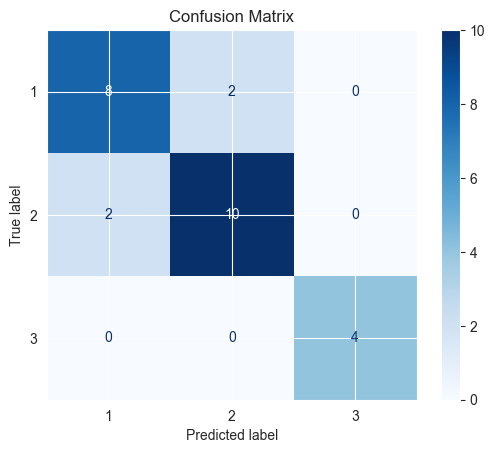

In [63]:
# Ambil label kelas dari model
labels = clf.classes_

# Evaluasi
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, labels=labels, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [66]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import scipy.stats as stats

# Asumsikan `data` sudah dibaca seperti sebelumnya
X = data[['Usia', 'Pendidikan_Terakhir', 'Pekerjaan_Kepala_Keluarga',
          'Pendapatan_Bulanan', 'Pengeluaran_Bulanan', 'Jumlah_Tanggungan',
          'Jumlah_Kendaraan', 'Kepemilikan_Kendaraan', 'Kepemilikan_Aset']]
y = data['Cluster']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
categorical_features = ['Pendidikan_Terakhir', 'Pekerjaan_Kepala_Keluarga', 'Kepemilikan_Kendaraan', 'Kepemilikan_Aset']
numeric_features = ['Usia','Pendapatan_Bulanan','Pengeluaran_Bulanan','Jumlah_Tanggungan','Jumlah_Kendaraan']

encoder = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# Dapatkan fitur setelah one-hot
X_train_encoded = encoder.fit_transform(X_train)
feature_names = encoder.get_feature_names_out()

# Model multinomial
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train_encoded, y_train)

# Ambil koefisien dan prediksi probabilitas
coef = model.coef_  # shape: (n_classes, n_features)
intercept = model.intercept_

# Prediksi probabilitas
probs = model.predict_proba(X_train_encoded)

# Hitung p-value untuk setiap koefisien
n_classes = coef.shape[0]
n_obs = X_train_encoded.shape[0]
p_values = []

for k in range(n_classes):
    p = probs[:, k].reshape(-1, 1)
    W = np.diagflat(p * (1 - p))  # Matriks bobot
    X_design = np.hstack([np.ones((X_train_encoded.shape[0], 1)), X_train_encoded])
    try:
        cov_matrix = np.linalg.inv(X_design.T @ W @ X_design)
        se = np.sqrt(np.diag(cov_matrix))
        z = np.hstack([intercept[k], coef[k]]) / se
        p_val = 2 * (1 - stats.norm.cdf(np.abs(z)))
    except np.linalg.LinAlgError:
        # Jika singular, isi dengan NaN
        p_val = [np.nan] * (X_design.shape[1])
    p_values.append(p_val)

# Buat DataFrame hasil
columns = ['Intercept'] + feature_names.tolist()
pval_df = pd.DataFrame(p_values, columns=columns, index=[f"Class_{c}" for c in model.classes_])
coef_df = pd.DataFrame(np.hstack([intercept[:, None], coef]), columns=columns, index=[f"Class_{c}" for c in model.classes_])

print("Koefisien:\n", coef_df.round(4))
print("\nP-Values:\n", pval_df.round(4))


Koefisien:
          Intercept  cat__Pendidikan_Terakhir_2  cat__Pendidikan_Terakhir_3  \
Class_1    -0.4012                      0.2514                     -0.5926   
Class_2     0.7929                     -0.0295                      0.9201   
Class_3    -0.3917                     -0.2219                     -0.3275   

         cat__Pendidikan_Terakhir_4  cat__Pendidikan_Terakhir_5  \
Class_1                      0.0038                      0.0088   
Class_2                     -0.0447                      0.0677   
Class_3                      0.0408                     -0.0765   

         cat__Pendidikan_Terakhir_6  cat__Pekerjaan_Kepala_Keluarga_2  \
Class_1                      0.0281                           -0.0038   
Class_2                     -0.0722                            0.1752   
Class_3                      0.0441                           -0.1714   

         cat__Pekerjaan_Kepala_Keluarga_3  cat__Pekerjaan_Kepala_Keluarga_4  \
Class_1                           

C:\Users\cikar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# 1. Load dan siapkan data
data = pd.read_excel("hasil_encodee.xlsx")

# Pastikan kolom numerik valid
num_cols = ['Usia', 'Pendapatan_Bulanan', 'Pengeluaran_Bulanan', 'Jumlah_Tanggungan', 'Jumlah_Kendaraan']
for col in num_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

X = data[['Usia', 'Pendidikan_Terakhir', 'Pekerjaan_Kepala_Keluarga', 'Pendapatan_Bulanan',
          'Pengeluaran_Bulanan', 'Jumlah_Tanggungan', 'Jumlah_Kendaraan',
          'Kepemilikan_Kendaraan', 'Kepemilikan_Aset']]
y = data['Cluster']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. One-hot encoding
categorical_features = ['Pendidikan_Terakhir', 'Pekerjaan_Kepala_Keluarga',
                        'Kepemilikan_Kendaraan', 'Kepemilikan_Aset']
numeric_features = ['Usia', 'Pendapatan_Bulanan', 'Pengeluaran_Bulanan',
                    'Jumlah_Tanggungan', 'Jumlah_Kendaraan']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

X_encoded = preprocessor.fit_transform(X_train)
feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)) + numeric_features
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)

# 4. Logistic Regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_encoded_df, y_train)

# 5. Hitung p-value manual
preds = model.predict_proba(X_encoded_df)
coefs = model.coef_
n_classes, n_features = coefs.shape

# Stabilkan inversi dengan pseudo-inverse
X_design = np.hstack([np.ones((X_encoded_df.shape[0], 1)), X_encoded_df.values])
var_betas = []
for i in range(coefs.shape[0]):
    p = preds[:, i]
    W = np.diag(p * (1 - p) + 1e-5)  # tambah noise kecil agar tidak singular
    XtWX_inv = np.linalg.pinv(X_design.T @ W @ X_design)  # gunakan pseudo-inverse
    var_betas.append(np.diag(XtWX_inv)[1:])

var_betas = np.array(var_betas)
z_scores = coefs / np.sqrt(var_betas)
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# 6. Rata-rata p-value per variabel
feature_df = pd.DataFrame(p_values, columns=feature_names)
feature_df.index = [f"Class_{i}" for i in range(len(model.classes_))]

grouped_vars = {
    'Pendidikan_Terakhir': [col for col in feature_names if col.startswith('Pendidikan_Terakhir_')],
    'Pekerjaan_Kepala_Keluarga': [col for col in feature_names if col.startswith('Pekerjaan_Kepala_Keluarga_')],
    'Kepemilikan_Kendaraan': [col for col in feature_names if col.startswith('Kepemilikan_Kendaraan_')],
    'Kepemilikan_Aset': [col for col in feature_names if col.startswith('Kepemilikan_Aset_')],
    'Usia': ['Usia'],
    'Pendapatan_Bulanan': ['Pendapatan_Bulanan'],
    'Pengeluaran_Bulanan': ['Pengeluaran_Bulanan'],
    'Jumlah_Tanggungan': ['Jumlah_Tanggungan'],
    'Jumlah_Kendaraan': ['Jumlah_Kendaraan']
}

pval_summary = pd.DataFrame(index=grouped_vars.keys(), columns=feature_df.index)
for var, cols in grouped_vars.items():
    for cls in feature_df.index:
        pval_summary.loc[var, cls] = feature_df.loc[cls, cols].astype(float).mean()

# 7. Tampilkan
print("\nP-Value per Variabel:\n")
print(pval_summary.astype(float).round(4))


In [ ]:
# 7. Hitung p-value
preds = model.predict_proba(X_encoded_df)
coefs = model.coef_

X_design = np.hstack([np.ones((X_encoded_df.shape[0], 1)), X_encoded_df.values])
var_betas = []
for i in range(coefs.shape[0]):
    p = preds[:, i]
    W = np.diag(p * (1 - p) + 1e-5)  # tambah noise kecil
    XtWX_inv = np.linalg.pinv(X_design.T @ W @ X_design)
    var_betas.append(np.diag(XtWX_inv)[1:])  # hilangkan intercept

var_betas = np.array(var_betas)
z_scores = coefs / np.sqrt(var_betas)
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# 8. Buat tabel hasil
results = []
for i, cls in enumerate(model.classes_):
    for j, var in enumerate(feature_names):
        results.append({
            'Kelas': cls,
            'Variabel': var,
            'Koefisien': coefs[i, j],
            'Standard Error': np.sqrt(var_betas[i, j]),
            'Z': z_scores[i, j],
            'P > |Z|': p_values[i, j]
        })

result_df = pd.DataFrame(results)

# 9. Tampilkan
print("\nRingkasan Koefisien, SE, Z, dan P-value per Variabel per Kelas:\n")
print(result_df.round(4))


In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# === PREPROCESSING ===
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
], remainder='passthrough')

X_encoded = preprocessor.fit_transform(X_train)

# Buat nama fitur (tanpa intercept dulu)
feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)) + numeric_features

# Tambahkan konstanta ke daftar nama fitur
feature_names_with_const = ['Intercept'] + feature_names
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)

# === FIT MODEL ===
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_encoded_df, y_train)

# === PREDIKSI & DESAIN ===
preds = model.predict_proba(X_encoded_df)
coefs = model.coef_  # shape: (n_classes, n_features)
n_classes, n_features = coefs.shape

# Tambahkan intercept ke desain matrix
X_design = np.hstack([np.ones((X_encoded_df.shape[0], 1)), X_encoded_df.values])

# === PERHITUNGAN STATISTIK ===
intercepts = []
var_betas = []
for i in range(coefs.shape[0]):
    p = preds[:, i]
    W = np.diag(p * (1 - p) + 1e-5)  # stabilitas numerik
    XtWX_inv = np.linalg.pinv(X_design.T @ W @ X_design)
    var_beta = np.diag(XtWX_inv)
    var_betas.append(var_beta)

var_betas = np.array(var_betas)
standard_errors = np.sqrt(var_betas)

# Gabungkan intercept dan koefisien
coefs_full = np.hstack([model.intercept_[:, np.newaxis], model.coef_])
z_scores = coefs_full / standard_errors
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Buat DataFrame dengan semua informasi
pval_df = pd.DataFrame(p_values, columns=feature_names_with_const, index=[f"Class_{i}" for i in range(n_classes)])
zscore_df = pd.DataFrame(z_scores, columns=feature_names_with_const, index=[f"Class_{i}" for i in range(n_classes)])
stderr_df = pd.DataFrame(standard_errors, columns=feature_names_with_const, index=[f"Class_{i}" for i in range(n_classes)])

# === PENGELOMPOKAN VARIABEL ===
grouped_vars = {
    'Intercept': ['Intercept'],
    'Pendidikan_Terakhir': [col for col in feature_names if col.startswith('Pendidikan_Terakhir_')],
    'Pekerjaan_Kepala_Keluarga': [col for col in feature_names if col.startswith('Pekerjaan_Kepala_Keluarga_')],
    'Kepemilikan_Kendaraan': [col for col in feature_names if col.startswith('Kepemilikan_Kendaraan_')],
    'Kepemilikan_Aset': [col for col in feature_names if col.startswith('Kepemilikan_Aset_')],
    'Usia': ['Usia'],
    'Pendapatan_Bulanan': ['Pendapatan_Bulanan'],
    'Pengeluaran_Bulanan': ['Pengeluaran_Bulanan'],
    'Jumlah_Tanggungan': ['Jumlah_Tanggungan'],
    'Jumlah_Kendaraan': ['Jumlah_Kendaraan']
}

# === AGGREGASI ===
def aggregate_stat(df):
    out = pd.DataFrame(index=grouped_vars.keys(), columns=df.index)
    for var, cols in grouped_vars.items():
        for cls in df.index:
            out.loc[var, cls] = df.loc[cls, cols].astype(float).mean()
    return out.astype(float)

# Ringkasan akhir
pval_summary = aggregate_stat(pval_df)
zscore_summary = aggregate_stat(zscore_df)
stderr_summary = aggregate_stat(stderr_df)

# OUTPUT
pval_summary, zscore_summary, stderr_summary
